In [1]:
import glob
from string import punctuation

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences

# Models
from keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from keras.layers import Input, Embedding, Dropout, LSTM, Conv2D, Dense, Activation, Reshape, Flatten
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

[]

***

In [3]:
PATH_TO_DATA = '../data/all_data/'

## Understanding and formating the data

In [4]:
guis_code = glob.glob(PATH_TO_DATA + '*.gui')
guis_sketch = glob.glob(PATH_TO_DATA + '*.png')

assert len(guis_code) == len(guis_sketch)

In [5]:
demo_sketch_id = '00150311-A7AE-4804-8B7D-9273687B4FC0'

### Init Sketch to DSL Code map

In [6]:
def get_sketch_id_code_pair(path_to_code):
    sketch_id = path_to_code.split('/')[3].split('.')[0]
    with open(path_to_code, 'r') as f:
        code = f.read()

    return (sketch_id, code)


def init_sketch_id_code_map(paths):
    sketch_id_code_map = dict()

    for path in paths:
        sketch_id, code = get_sketch_id_code_pair(path)
        sketch_id_code_map[sketch_id] = code

    return sketch_id_code_map


sketch_id_code_map = init_sketch_id_code_map(guis_code)

In [7]:
print(sketch_id_code_map[demo_sketch_id])

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
single {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}



### Load / Show the Sketch

In [8]:
def load_sketch(sketch_id, target_size=(299, 299), preprocess=True) :
    sketch = image.load_img(PATH_TO_DATA+sketch_id+'.png', target_size=target_size)
    x = image.img_to_array(sketch)
    
    if preprocess:
        x = preprocess_input(x)

    return x

def show_sketch(path_to_sketch):
    Image.open(path_to_sketch).show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


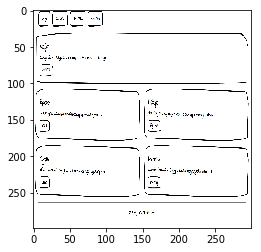

In [9]:
plt.imshow(load_sketch(demo_sketch_id));

In [10]:
show_sketch(PATH_TO_DATA+demo_sketch_id+'.png')

***

## Create a Vocabulary

In [11]:
with open('../vocabulary.txt', 'r') as f:
    vocabulary = f.read().split()

vocabulary.insert(0, '0')

In [12]:
len(vocabulary)

18

### Word2Idx, Idx2Word maps

In [13]:
word2idx = {val: key for key, val in enumerate(vocabulary)}
idx2word = {key: val for key, val in enumerate(vocabulary)}

In [14]:
word2idx

{'0': 0,
 ',': 1,
 '{': 2,
 '}': 3,
 'small-title': 4,
 'text': 5,
 'quadruple': 6,
 'row': 7,
 'btn-inactive': 8,
 'btn-orange': 9,
 'btn-green': 10,
 'btn-red': 11,
 'double': 12,
 '<START>': 13,
 'header': 14,
 'btn-active': 15,
 '<END>': 16,
 'single': 17}

In [15]:
idx2word

{0: '0',
 1: ',',
 2: '{',
 3: '}',
 4: 'small-title',
 5: 'text',
 6: 'quadruple',
 7: 'row',
 8: 'btn-inactive',
 9: 'btn-orange',
 10: 'btn-green',
 11: 'btn-red',
 12: 'double',
 13: '<START>',
 14: 'header',
 15: 'btn-active',
 16: '<END>',
 17: 'single'}

***

## Max DSL Code Length

In [16]:
def tokenize_dsl_code(code):
    tokens = code.split()
    final_tokens = []

    for token in tokens:
        if ',' in token:
            final_tokens.append(token.split(',')[0])
            final_tokens.append(',')
        else:
            final_tokens.append(token)

    return final_tokens

In [17]:
print('Total number of DSL Codes: {}'.format(len(sketch_id_code_map.values())))

Total number of DSL Codes: 1700


In [18]:
longets_code = max(
    sketch_id_code_map.values(), key=lambda x: len(tokenize_dsl_code(x)))

print('Longes code:')
print('=' * 30)
print()
print(longets_code)

Longes code:

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}



In [19]:
max_code_length = len(tokenize_dsl_code(longets_code)) + 2

print('Max DSL Code Length: {}'.format(max_code_length))

Max DSL Code Length: 117


***

## Train/Dev/Test split

In [20]:
len(sketch_id_code_map)

1700

In [21]:
SPLIT = (.9, .05, .05)

In [22]:
items = list(sketch_id_code_map.items())
total_num = len(items)

borders = (
    int(total_num * SPLIT[0]),
    int(total_num * SPLIT[0]) + int(total_num * SPLIT[1]),
    int(total_num * SPLIT[0]) + int(total_num * SPLIT[1]) + int(
        total_num * SPLIT[2]),
)

train_sketch_id_code_map = dict(items[0:borders[0]])
dev_sketch_id_code_map = dict(items[borders[0]:borders[1]])
test_sketch_id_code_map = dict(items[borders[1]:borders[2]])

In [23]:
assert len(train_sketch_id_code_map) + len(dev_sketch_id_code_map) + len(
    test_sketch_id_code_map) == len(sketch_id_code_map)

In [24]:
print('Train Set size: {}'.format(len(train_sketch_id_code_map)))
print('Dev Set size: {}'.format(len(dev_sketch_id_code_map)))
print('Test Set size: {}'.format(len(test_sketch_id_code_map)))

Train Set size: 1530
Dev Set size: 85
Test Set size: 85


***

## Data Generator

In [25]:
# data generator, intended to be used in a call to model.fit_generator()


def data_generator(sketch_id_code_set, word2idx, batch_size, maxlen=max_code_length):
    X_img = np.zeros((batch_size, 299, 299, 3))
    X_seq = []
    Y_seq = []
    n = 0

    # loop for ever over images
    while True:
        for sketch_id, code in sketch_id_code_set.items():
            # load sketch
            sketch = load_sketch(sketch_id, preprocess=True)
            X_img[n] = sketch

            # encode the sequence
            y_seq = [word2idx[word] for word in tokenize_dsl_code(code)
                     ] + [word2idx['<END>']]
            x_seq = [word2idx['<START>']] + y_seq[:-1]

            Y_seq.append(y_seq)
            X_seq.append(x_seq)

            n += 1
            # yield the batch data
            if n == batch_size:
                X_seq = pad_sequences(X_seq, maxlen=maxlen, padding='post')
                Y_seq = pad_sequences(Y_seq, maxlen=maxlen, padding='post')

                # One-hot
                Y_seq = [[
                    to_categorical(idx, len(vocabulary)) for idx in sent
                ] for sent in Y_seq]

                yield [[X_img, X_seq], np.array(Y_seq)]

                X_img = np.zeros((batch_size, 299, 299, 3))
                X_seq = []
                Y_seq = []
                n = 0

***

In [26]:
EMBEDDING_DIM = 300
NUM_HIDDEN_NEURONS = 512

# Sketch Encoder (ConvNet)

In [27]:
img_in = Input((299, 299, 3), name='image_input')

x = Conv2D(16, (3,3), activation='relu', padding='valid', name='conv_16')(img_in)
x = Conv2D(16, (3,3), activation='relu', padding='same', strides=2, name='conv_16_2')(x)

x = Conv2D(32, (3,3), activation='relu', padding='same',  name='conv_32')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same', strides=2, name='conv_32_2')(x)

x = Conv2D(64, (3,3), activation='relu', padding='same', name='conv_64')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same', strides=2, name='conv_64_2')(x)

x = Conv2D(128, (3,3), activation='relu', padding='same', name='conv_128')(x)
x = Flatten(name='flatten')(x)

x = Dense(1024, activation='relu', name='dense_1')(x)
x = Dropout(0.3, name='dropout_1')(x)

x = Dense(1024, activation='relu', name='dense_2')(x)
x = Dropout(0.3, name='dropout_2')(x)

x = Dense(EMBEDDING_DIM, activation='sigmoid', name='dense_encoder')(x)
x = Reshape((1, EMBEDDING_DIM), name='embedding_reshapor')(x)
    
sketch_encoder = Model(img_in, x, name='sketch_encoder')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
plot_model(sketch_encoder, to_file='sketch_encoder.png', show_shapes=True, show_layer_names=True)

print(sketch_encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 299, 299, 3)       0         
_________________________________________________________________
conv_16 (Conv2D)             (None, 297, 297, 16)      448       
_________________________________________________________________
conv_16_2 (Conv2D)           (None, 149, 149, 16)      2320      
_________________________________________________________________
conv_32 (Conv2D)             (None, 149, 149, 32)      4640      
_________________________________________________________________
conv_32_2 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
conv_64 (Conv2D)             (None, 75, 75, 64)        18496     
_________________________________________________________________
conv_64_2 (Conv2D)           (None, 38, 38, 64)        36928     
__________

***

# Sequence Decoder (LSTM)
<br>
A LSTM network

![LSTM_net](../img/LSTM.png)

In [30]:
# Sequence Input
seq_in = Input((max_code_length,), name='sequence_input')
sketch_emb_in = Input((1, EMBEDDING_DIM), name='sketch_emb_input')


# Embeddings
embeddings = Embedding(
    len(vocabulary),
    EMBEDDING_DIM,
    input_length=max_code_length,
    mask_zero=True,
    name='embeddings'
)
x = embeddings(seq_in)
    
# Dropout
embeddings_dropout = Dropout(0.5, name='embeddings_dropout')
x = embeddings_dropout(x)

# Sequence Decoder
lstm_decoder = LSTM(NUM_HIDDEN_NEURONS, return_sequences=True, return_state=True, name='lstm_decoder')

# Get the context from the Sketch
_, h_state, c_state = lstm_decoder(sketch_emb_in)

# Generate the code
x, _, _ = lstm_decoder(x, initial_state=[h_state, c_state])

# Dense -> Softmax
dense_decoder = Dense(len(vocabulary), name='dense_decoder')
x = dense_decoder(x)
softmax_decoder = Activation('softmax', name='softmax_decoder')
x = softmax_decoder(x)
    
sequence_decoder = Model(inputs=[seq_in, sketch_emb_in], outputs=x, name='sequence_decoder')


In [31]:
plot_model(sequence_decoder, to_file='sequence_decoder.png', show_shapes=True, show_layer_names=True)

print(sequence_decoder.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, 117)          0                                            
__________________________________________________________________________________________________
embeddings (Embedding)          (None, 117, 300)     5400        sequence_input[0][0]             
__________________________________________________________________________________________________
sketch_emb_input (InputLayer)   (None, 1, 300)       0                                            
__________________________________________________________________________________________________
lstm_decoder (LSTM)             multiple             1665024     sketch_emb_input[0][0]           
                                                                 embeddings_dropout[0][0]         
          

***

# Model

![NIC_model](../img/Model.png)

In [32]:
sketch_emb = sketch_encoder(img_in)
seq_out = sequence_decoder([seq_in, sketch_emb])

# Build the model
model = Model(inputs=[img_in, seq_in], outputs=seq_out, name='model')


### Visualize the model

In [33]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 117)          0                                            
__________________________________________________________________________________________________
sketch_encoder (Model)          (None, 1, 300)       190772028   image_input[0][0]                
__________________________________________________________________________________________________
sequence_decoder (Model)        (None, 117, 18)      1679658     sequence_input[0][0]             
                                                                 sketch_encoder[1][0]             
Total para

***

# Inference

![LSTM_sampling](../img/Sampling.png)

In [40]:
def init_inference_decoder():
    h_state_input = Input((NUM_HIDDEN_NEURONS, ), name='h_state_input')
    c_state_input = Input((NUM_HIDDEN_NEURONS, ), name='c_state_input')

    embedded_seq = embeddings(seq_in)
    embedded_seq = embeddings_dropout(embedded_seq)

    output_tokens, h_state, c_state = lstm_decoder(
        embedded_seq, initial_state=[h_state_input, c_state_input])
    output_tokens = dense_decoder(output_tokens)
    output_tokens = softmax_decoder(output_tokens)

    inference_decoder = Model([seq_in, h_state_input, c_state_input],
                              [output_tokens, h_state, c_state])

    return inference_decoder


def get_sketch_embedding(sketch):
    return sketch_encoder.predict(np.expand_dims(sketch, 0))


def get_initial_lstm_states(sketch):
    states_model = Model(sketch_emb_in, lstm_decoder(sketch_emb_in)[1:])
    sketch_emb = get_sketch_embedding(sketch)
    return states_model.predict(sketch_emb)


def greedy_search_inference(sketch):
    inference_decoder = init_inference_decoder()
    
    # Get the context of the Sketch
    states_values = get_initial_lstm_states(sketch)

    target_seq = np.zeros((1, max_code_length))
    target_seq[0, 0] = word2idx['<START>']

    stop_condition = False
    decoded_tokens = []

    while not stop_condition:
        output_tokens, h_state, c_state = inference_decoder.predict(
            [target_seq] + states_values)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_word = idx2word[sampled_token_index]
        decoded_tokens.append(sampled_word)

        # Exit condition
        if (sampled_word == '<END>' or len(decoded_tokens) >= max_code_length):
            stop_condition = True

        target_seq = np.zeros((1, max_code_length))
        target_seq[0, 0] = sampled_token_index

        states_values = [h_state, c_state]

    return ' '.join(decoded_tokens)

In [41]:
# 'subdivsion magnificant affectionately '

greedy_search_inference(load_sketch(demo_sketch_id))

'double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double double'

***

## Run Train

### Callbacks

In [35]:
filepath="weights/weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=True)

def on_epoch_end(epoch, logs):
    if epoch % 5 == 0:
        print()
        print('Sampled:')
        print('='*30)
        print(inference(load_sketch(demo_sketch)))
        print()
        print()

lambda_cb = LambdaCallback(on_epoch_end=on_epoch_end)

callbacks = [checkpoint, lambda_cb]

In [36]:
model.compile(Adam(0.0001), loss='categorical_crossentropy')

In [38]:
batch_size = 32
steps = len(train_sketch_code) // batch_size

model.fit_generator(
    data_generator(train_sketch_code, word2idx, max_code_length, batch_size),
    steps_per_epoch=steps,
    epochs=100,
    verbose=True,
    callbacks=callbacks,
)

Epoch 1/100
47/47 [==============================] - 87s 2s/step - loss: 2.4170

Epoch 00001: saving model to weights/weights-01.hdf5


/usr/local/lib/python3.5/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_decoder was passed non-serializable keyword arguments: {'mask': [<tf.Tensor 'sequence_decoder/embeddings/NotEqual:0' shape=(?, 117) dtype=bool>, None, None], 'initial_state': [<tf.Tensor 'h_state_input:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'c_state_input:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '



Sampled:
header btn-inactive btn-inactive btn-inactive btn-inactive btn-inactive btn-inactive , , , , , , , , , , } } } } } } } } } } , } , } , } , } } , } } , } , } } , } , } } , } , } } , } } , } , } } , } } , } } , } } , } } , } } , } } , } } , }


Epoch 2/100
47/47 [==============================] - 87s 2s/step - loss: 2.0437

Epoch 00002: saving model to weights/weights-02.hdf5
Epoch 3/100
47/47 [==============================] - 94s 2s/step - loss: 1.9787

Epoch 00003: saving model to weights/weights-03.hdf5
Epoch 4/100
47/47 [==============================] - 93s 2s/step - loss: 1.9153

Epoch 00004: saving model to weights/weights-04.hdf5
Epoch 5/100
47/47 [==============================] - 94s 2s/step - loss: 1.8191

Epoch 00005: saving model to weights/weights-05.hdf5
Epoch 6/100
47/47 [==============================] - 94s 2s/step - loss: 1.5209

Epoch 00006: saving model to weights/weights-06.hdf5

Sampled:
header { btn-inactive , btn-inactive , btn-inactive btn-inactive bt

RuntimeError: Unable to flush file's cached information (file write failed: time = Sat Mar 23 22:19:27 2019
, filename = 'weights/weights-38.hdf5', file descriptor = 83, errno = 28, error message = 'No space left on device', buf = 0x15129e30, total write size = 9112, bytes this sub-write = 9112, bytes actually written = 18446744073709551615, offset = 4096)

In [45]:
model.load_weights('./weights/weights-24.hdf5')
model.compile(Adam(0.00001), loss='categorical_crossentropy')

In [46]:
batch_size = 32
steps = len(train_sketch_code) // batch_size

model.fit_generator(
    data_generator(train_sketch_code, word2idx, max_code_length, batch_size),
    steps_per_epoch=steps,
    epochs=100,
    verbose=True,
    callbacks=callbacks,
)

Epoch 1/100
47/47 [==============================] - 88s 2s/step - loss: 0.0043

Epoch 00001: saving model to weights/weights-01.hdf5

Sampled:
header { btn-inactive , btn-inactive , btn-inactive , btn-inactive } row { single { small-title , text , btn-orange } } row { double { small-title , text , btn-orange } double { small-title , text , btn-orange } } row { double { small-title , text , btn-orange } double { small-title , text , btn-orange } } <END>


Epoch 2/100
47/47 [==============================] - 83s 2s/step - loss: 0.0028

Epoch 00002: saving model to weights/weights-02.hdf5
Epoch 3/100
47/47 [==============================] - 89s 2s/step - loss: 0.0025

Epoch 00003: saving model to weights/weights-03.hdf5
Epoch 4/100
47/47 [==============================] - 88s 2s/step - loss: 0.0025

Epoch 00004: saving model to weights/weights-04.hdf5
Epoch 5/100
47/47 [==============================] - 90s 2s/step - loss: 0.0023

Epoch 00005: saving model to weights/weights-05.hdf5
Epoc

KeyboardInterrupt: 

***

## Dev

In [38]:
model.load_weights('./weights/weights-11.hdf5')

In [42]:
inference(load_sketch('05603517-666B-44EC-86D1-DFB14F81C639'))

'header { btn-inactive , btn-inactive , btn-inactive , btn-inactive , btn-inactive } row { double { small-title , text , btn-orange } double { small-title , text , btn-orange } } row { quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } } row { single { small-title , text , btn-orange } } <END>'

In [44]:
print(dev_sketch_code['05603517-666B-44EC-86D1-DFB14F81C639'])

header {
btn-inactive, btn-inactive, btn-inactive, btn-inactive, btn-inactive
}
row {
double {
small-title, text, btn-orange
}
double {
small-title, text, btn-orange
}
}
row {
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
quadruple {
small-title, text, btn-orange
}
}
row {
single {
small-title, text, btn-orange
}
}



In [39]:
dsl_file = inference(load_sketch(demo_sketch))

In [40]:
dsl_file = dsl_file.replace('{', '{8').replace('}', '8}8')
dsl_file = dsl_file.replace(' ', '')
dsl_file = dsl_file.split('8')
dsl_file = list(filter(None, dsl_file))

In [41]:
dsl_file

['header{',
 'btn-inactive,btn-inactive,btn-inactive,btn-inactive',
 '}',
 'row{',
 'single{',
 'small-title,text,btn-orange',
 '}',
 '}',
 'row{',
 'double{',
 'small-title,text,btn-orange',
 '}',
 'double{',
 'small-title,text,btn-orange',
 '}',
 '}',
 'row{',
 'double{',
 'small-title,text,btn-orange',
 '}',
 'double{',
 'small-title,text,btn-orange',
 '}',
 '}',
 '<END>']